In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
# from tslearn.metrics import SoftDTWLossPyTorch

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
# load data

# load data std
psort_filename = 'std_data.mat'
data = loadmat(psort_filename)
std_data = data['std_data']
std_data = torch.squeeze(torch.tensor(std_data))

# scale factor
scale = 1.0

psort_filename = 'all_cs_waveform.mat'
data = loadmat(psort_filename)
cs_waveform = data['all_cs_waveform']
cs_waveform = [torch.tensor(cs_waveform[i][0]/std_data[i]*scale).to(torch.float) for i in range(len(cs_waveform))] # list: time*sample

psort_filename = 'all_ss_waveform.mat'
data = loadmat(psort_filename)
ss_waveform = data['all_ss_waveform']
ss_waveform = [torch.tensor(ss_waveform[i][0]/std_data[i]*scale).to(torch.float) for i in range(len(ss_waveform))] # list: time*sample



C:\Users\baozi\AppData\Local\Temp\ipykernel_22984\3872097845.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cs_waveform = [torch.tensor(cs_waveform[i][0]/std_data[i]*scale).to(torch.float) for i in range(len(cs_waveform))] # list: time*sample
C:\Users\baozi\AppData\Local\Temp\ipykernel_22984\3872097845.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ss_waveform = [torch.tensor(ss_waveform[i][0]/std_data[i]*scale).to(torch.float) for i in range(len(ss_waveform))] # list: time*sample


In [28]:
class MyDataset(Dataset):
    def __init__(self, cs_waveform, ss_waveform):
        super(MyDataset,self).__init__()
        self.N = len(cs_waveform)
        self.S_cs = [w.size(1) for w in cs_waveform]
        self.S_ss = [w.size(1) for w in ss_waveform]
        self.cs_waveform = cs_waveform
        self.ss_waveform = ss_waveform

        self.minibatch = 10

    def __len__(self):
        return self.N
    
    def __getitem__(self,item):
        return (torch.squeeze(torch.mean(self.cs_waveform[item][:,torch.randint(self.S_cs[item],(self.minibatch,))],dim=-1)), torch.squeeze(torch.mean(self.cs_waveform[item][:,torch.randint(self.S_cs[item],(self.minibatch,))],dim=-1)), 
                torch.squeeze(torch.mean(self.ss_waveform[item][:,torch.randint(self.S_ss[item],(self.minibatch,))],dim=-1)), torch.squeeze(torch.mean(self.ss_waveform[item][:,torch.randint(self.S_ss[item],(self.minibatch,))],dim=-1)))



In [29]:
train_idx = range(53)
test_idx = [53,54,55,56]

dataset_train = MyDataset([cs_waveform[idx] for idx in train_idx],[ss_waveform[idx] for idx in train_idx])
dataloader_train = DataLoader(dataset_train,batch_size=len(train_idx),shuffle=True)

dataset_test = MyDataset([cs_waveform[idx] for idx in test_idx],[ss_waveform[idx] for idx in test_idx])
dataloader_test = DataLoader(dataset_test,batch_size=len(test_idx),shuffle=False)


In [21]:
####################### Basic
class SelfAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv1d(in_channels, out_channels, 1)
        self.key = nn.Conv1d(in_channels, out_channels, 1)
        self.value = nn.Conv1d(in_channels, out_channels, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Shape of x: (batch_size, channels, sequence_length)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        # Compute attention scores
        attention_scores = torch.bmm(query.transpose(1, 2), key)
        attention_scores = self.softmax(attention_scores)
        
        # Apply attention scores to values
        attended_values = torch.bmm(attention_scores, value.transpose(1, 2))
        attended_values = attended_values.transpose(1, 2)
        return attended_values

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes):
        super(InceptionBlock,self).__init__()
        self.branches = nn.ModuleList()

        for kernel_size in kernel_sizes:
            padding = kernel_size // 2
            self.branches.append(
                nn.Conv1d(in_channels,out_channels,kernel_size,padding=padding)
            )
        
    def forward(self,x):
        outputs = [conv(x) for conv in self.branches]
        x = torch.cat(outputs,dim=1)
        return x

class CSseq2seq(nn.Module):
    def __init__(self):
        super(CSseq2seq, self).__init__()

        self.IB_kernelsizes = [3,7,11,15]
        
        # Block input
        self.attn1 = SelfAttention(2,12)
        self.attn1_bn = nn.BatchNorm1d(12,affine=True)
        self.ib1 = InceptionBlock(2,12,self.IB_kernelsizes)
        self.ib1_bn = nn.BatchNorm1d(48,affine=True)
        self.conv1 = nn.Conv1d(60,10,1)
        self.conv1_bn = nn.BatchNorm1d(10,affine=True)
        self.act1 = nn.ReLU()

        # Block middle
        self.midBlockRepeat = 4
        self.attn_mid = nn.ModuleList()
        self.attn_mid_bn = nn.ModuleList()
        self.ib_mid = nn.ModuleList()
        self.ib_mid_bn = nn.ModuleList()
        self.conv_mid = nn.ModuleList()
        self.conv_mid_bn = nn.ModuleList()
        self.act_mid = nn.ModuleList()
        for i in range(self.midBlockRepeat):
            self.attn_mid.append(SelfAttention(12,12))
            self.attn_mid_bn.append(nn.BatchNorm1d(12,affine=True))
            self.ib_mid.append(InceptionBlock(12,12,self.IB_kernelsizes))
            self.ib_mid_bn.append(nn.BatchNorm1d(48,affine=True))
            self.conv_mid.append(nn.Conv1d(60,12,1))
            self.conv_mid_bn.append(nn.BatchNorm1d(12,affine=True))
            self.act_mid.append(nn.ReLU())

        # Block output
        self.attn4 = SelfAttention(12,12)
        self.attn4_bn = nn.BatchNorm1d(12,affine=True)
        self.ib4 = InceptionBlock(12,12,self.IB_kernelsizes)
        self.ib4_bn = nn.BatchNorm1d(48,affine=True)

        # output
        self.fc = nn.Conv1d(60,1,1)

    def htransforms(self, data):
        N = data.shape[-1]
        
        transforms = torch.fft.fft(data,dim=-1)
        transforms[:, 1:N//2]      *= -1j      # positive frequency
        transforms[:, (N+2)//2 + 1: N] *= +1j # negative frequency
        transforms[:,0] = 0; # DC signal
        if N % 2 == 0:
            transforms[:, N//2] = 0; # the (-1)**n term
        
        # Do IFFT
        transforms = torch.fft.ifft(transforms)

        # return real and img part
        return torch.cat([torch.real(transforms)[:,None,:],torch.imag(transforms).to(torch.float)[:,None,:]],dim=1)

    def forward(self, x):
        x = self.htransforms(x)
        
        # Block input
        x_copy = x.detach().clone()
        xx = torch.cat([self.attn1_bn(self.attn1(x)),self.ib1_bn(self.ib1(x))],dim=1)
        xx = self.conv1_bn(self.conv1(xx))
        xx = self.act1(xx)
        x = torch.cat([x_copy,xx],dim=1)

        # Block middle
        for i in range(self.midBlockRepeat):
            x_copy = x.detach().clone()
            xx = torch.cat([self.attn_mid_bn[i](self.attn_mid[i](x)),self.ib_mid_bn[i](self.ib_mid[i](x))],dim=1)
            xx = self.conv_mid_bn[i](self.conv_mid[i](xx))
            xx = xx + x_copy
            x = self.act_mid[i](xx)


        # Block output
        xx = torch.cat([self.attn4_bn(self.attn4(x)),self.ib4_bn(self.ib4(x))],dim=1)

        # output
        x = self.fc(xx)

        x = torch.squeeze(x,1)

        return x      

######################### Down block

class Down_SelfAttention(nn.Module):
    def __init__(self, in_channels, out_channels, down=5):
        super(Down_SelfAttention, self).__init__()

        self.mp = nn.MaxPool1d(down,down)
        self.query = nn.Conv1d(in_channels, out_channels, 1)
        self.key = nn.Conv1d(in_channels, out_channels, 1)
        self.value = nn.Conv1d(in_channels, out_channels, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Shape of x: (batch_size, channels, sequence_length)
        x_down = self.mp(x)

        query = self.query(x_down)
        key = self.key(x)
        value = self.value(x)
        
        # Compute attention scores
        attention_scores = torch.bmm(query.transpose(1, 2), key)
        attention_scores = self.softmax(attention_scores)
        
        # Apply attention scores to values
        attended_values = torch.bmm(attention_scores, value.transpose(1, 2))
        attended_values = attended_values.transpose(1, 2)
        return attended_values

class Down_InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes, down=5):
        super(Down_InceptionBlock,self).__init__()

        self.mp = nn.MaxPool1d(down,down)
        self.branches = nn.ModuleList()
        for kernel_size in kernel_sizes:
            padding = kernel_size // 2
            self.branches.append(
                nn.Conv1d(in_channels,out_channels,kernel_size,padding=padding)
            )
        
    def forward(self,x):
        x = self.mp(x)
        outputs = [conv(x) for conv in self.branches]
        x = torch.cat(outputs,dim=1)
        return x

######################### Up block

class Up_SelfAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up_SelfAttention, self).__init__()

        self.query = nn.Conv1d(in_channels, out_channels, 1)
        self.key = nn.Conv1d(in_channels, out_channels, 1)
        self.value = nn.Conv1d(in_channels, out_channels, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, x_jump):
        # Shape of x: (batch_size, channels, sequence_length)

        query = self.query(x_jump)
        key = self.key(x)
        value = self.value(x)
        
        # Compute attention scores
        attention_scores = torch.bmm(query.transpose(1, 2), key)
        attention_scores = self.softmax(attention_scores)
        
        # Apply attention scores to values
        attended_values = torch.bmm(attention_scores, value.transpose(1, 2))
        attended_values = attended_values.transpose(1, 2)
        return attended_values

class Up_InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes, up=5):
        super(Up_InceptionBlock,self).__init__()

        self.branches = nn.ModuleList()
        for kernel_size in kernel_sizes:
            padding = kernel_size // 2
            self.branches.append(
                nn.ConvTranspose1d(in_channels,out_channels,kernel_size,stride=up,padding=padding),
            )
        
        
    def forward(self,x):
        
        xx = [conv(x) for conv in self.branches]
        x = torch.cat(xx,dim=1)

        return x

######################### Unet
class Unet_CSseq2seq(nn.Module):
    def __init__(self,updown_scale=5):
        super(Unet_CSseq2seq, self).__init__()

        self.IB_kernelsizes = [3,7,11,15]
        
        # Block input
        self.attn1 = SelfAttention(2,12)
        self.attn1_bn = nn.BatchNorm1d(12,affine=True)
        self.ib1 = InceptionBlock(2,12,self.IB_kernelsizes)
        self.ib1_bn = nn.BatchNorm1d(48,affine=True)
        self.conv1 = nn.Conv1d(60,10,1)
        self.conv1_bn = nn.BatchNorm1d(10,affine=True)
        self.act1 = nn.ReLU()
        self.act1_bn = nn.BatchNorm1d(10,affine=True)

        # Block middle
        self.midBlockRepeat = 2
        self.attn_mid = nn.ModuleList()
        self.attn_mid_bn = nn.ModuleList()
        self.ib_mid = nn.ModuleList()
        self.ib_mid_bn = nn.ModuleList()
        self.conv_mid = nn.ModuleList()
        self.conv_mid_bn = nn.ModuleList()
        self.act_mid = nn.ModuleList()
        self.act_mid_bn = nn.ModuleList()
        for i in range(2*self.midBlockRepeat):
            self.attn_mid.append(SelfAttention(12,12))
            self.attn_mid_bn.append(nn.BatchNorm1d(12,affine=True))
            self.ib_mid.append(InceptionBlock(12,12,self.IB_kernelsizes))
            self.ib_mid_bn.append(nn.BatchNorm1d(48,affine=True))
            self.conv_mid.append(nn.Conv1d(60,12,1))
            self.conv_mid_bn.append(nn.BatchNorm1d(12,affine=True))
            self.act_mid.append(nn.ReLU())
            self.act_mid_bn.append(nn.BatchNorm1d(12,affine=True))

        # Down Block middle
        self.down_mp = nn.ModuleList()
        self.down_attn_mid = nn.ModuleList()
        self.down_attn_mid_bn = nn.ModuleList()
        self.down_ib_mid = nn.ModuleList()
        self.down_ib_mid_bn = nn.ModuleList()
        self.down_conv_mid = nn.ModuleList()
        self.down_conv_mid_bn = nn.ModuleList()
        self.down_act_mid = nn.ModuleList()
        self.down_act_mid_bn = nn.ModuleList()
        for i in range(self.midBlockRepeat):
            self.down_mp.append(nn.MaxPool1d(updown_scale, updown_scale))
            self.down_attn_mid.append(Down_SelfAttention(12,12,updown_scale))
            self.down_attn_mid_bn.append(nn.BatchNorm1d(12,affine=True))
            self.down_ib_mid.append(Down_InceptionBlock(12,12,self.IB_kernelsizes,updown_scale))
            self.down_ib_mid_bn.append(nn.BatchNorm1d(48,affine=True))
            self.down_conv_mid.append(nn.Conv1d(60,12,1))
            self.down_conv_mid_bn.append(nn.BatchNorm1d(12,affine=True))
            self.down_act_mid.append(nn.ReLU())
            self.down_act_mid_bn.append(nn.BatchNorm1d(12,affine=True))

        # Up Block middle
        self.upsample = nn.ModuleList()
        self.up_attn_mid = nn.ModuleList()
        self.up_attn_mid_bn = nn.ModuleList()
        self.up_ib_mid = nn.ModuleList()
        self.up_ib_mid_bn = nn.ModuleList()
        self.up_conv_mid = nn.ModuleList()
        self.up_conv_mid_bn = nn.ModuleList()
        self.up_act_mid = nn.ModuleList()
        self.up_act_mid_bn = nn.ModuleList()
        for i in range(self.midBlockRepeat):
            self.upsample.append(nn.Upsample(scale_factor=updown_scale,mode='linear', align_corners=True))
            self.up_attn_mid.append(Up_SelfAttention(12,12))
            self.up_attn_mid_bn.append(nn.BatchNorm1d(12,affine=True))
            self.up_ib_mid.append(Up_InceptionBlock(12,12,self.IB_kernelsizes,updown_scale))
            self.up_ib_mid_bn.append(nn.BatchNorm1d(48,affine=True))
            self.up_conv_mid.append(nn.Conv1d(60,12,1))
            self.up_conv_mid_bn.append(nn.BatchNorm1d(12,affine=True))
            self.up_act_mid.append(nn.ReLU())
            self.up_act_mid_bn.append(nn.BatchNorm1d(12,affine=True))
        
        # Block output
        self.attn4 = SelfAttention(12,12)
        self.attn4_bn = nn.BatchNorm1d(12,affine=True)
        self.ib4 = InceptionBlock(12,12,self.IB_kernelsizes)
        self.ib4_bn = nn.BatchNorm1d(48,affine=True)
        self.act4 = nn.Softmax(dim=-1)

        # output
        self.fc = nn.Conv1d(60,1,1)

    def htransforms(self, data):
        N = data.shape[-1]
        
        transforms = torch.fft.fft(data,dim=-1)
        transforms[:, 1:N//2]      *= -1j      # positive frequency
        transforms[:, (N+2)//2 + 1: N] *= +1j # negative frequency
        transforms[:,0] = 0; # DC signal
        if N % 2 == 0:
            transforms[:, N//2] = 0; # the (-1)**n term
        
        # Do IFFT
        transforms = torch.fft.ifft(transforms)

        # return real and img part
        return torch.cat([torch.real(transforms)[:,None,:],torch.imag(transforms).to(torch.float)[:,None,:]],dim=1)

    def forward(self, x):
        # x = self.htransforms(x)

        x = torch.cat([x[:,None,:],torch.diff(torch.nn.functional.pad(input=x, pad=(1,0), mode='constant', value=0),dim=-1)[:,None,:]],dim=1)

        # Block input
        x_copy = x.detach().clone()
        xx = torch.cat([self.attn1_bn(self.attn1(x)),self.ib1_bn(self.ib1(x))],dim=1)
        xx = self.conv1_bn(self.conv1(xx))
        xx = self.act1(xx)
        xx = self.act1_bn(xx)
        x = torch.cat([x_copy,xx],dim=1)

        # Block middle
        x_down_copy = []
        x_down_copy.append(x.detach().clone())
        
        for i in range(self.midBlockRepeat):

            # Down block
            x_copy = x.detach().clone()
            xx = torch.cat([self.down_attn_mid_bn[i](self.down_attn_mid[i](x)),self.down_ib_mid_bn[i](self.down_ib_mid[i](x))],dim=1)
            xx = self.down_conv_mid_bn[i](self.down_conv_mid[i](xx))
            xx = xx + self.down_mp[i](x_copy)
            xx = self.down_act_mid[i](xx)
            x = self.down_act_mid_bn[i](xx)

            x_copy = x.detach().clone()
            xx = torch.cat([self.attn_mid_bn[i](self.attn_mid[i](x)),self.ib_mid_bn[i](self.ib_mid[i](x))],dim=1)
            xx = self.conv_mid_bn[i](self.conv_mid[i](xx))
            xx = xx + x_copy
            xx = self.act_mid[i](xx)
            x = self.act_mid_bn[i](xx)

            x_down_copy.append(x.detach().clone())

        for i in range(self.midBlockRepeat):

            # Up block
            x_copy = x.detach().clone()
            x1 = self.up_attn_mid_bn[i](self.up_attn_mid[i](x,x_down_copy[-2-i]))
            x2 = self.up_ib_mid_bn[i](self.up_ib_mid[i](x))

            # align x1, x2 length before cat
            if x1.shape[-1] > x2.shape[-1]:
                x2 = torch.nn.functional.pad(input=x2, pad=(0,x1.shape[-1]-x2.shape[-1]), mode='constant', value=0)

            xx = torch.cat([x1,x2],dim=1)
            xx = self.up_conv_mid_bn[i](self.up_conv_mid[i](xx))

            # align x1, x2 length before cat
            x_add = self.upsample[i](x_copy)
            if xx.shape[-1] > x_add.shape[-1]:
                x_add = torch.nn.functional.pad(input=x_add, pad=(0,xx.shape[-1]-x_add.shape[-1]), mode='constant', value=0)

            xx = xx + x_add
            xx = self.up_act_mid[i](xx)
            x = self.up_act_mid_bn[i](xx)

            j = i + self.midBlockRepeat

            x_copy = x.detach().clone()
            xx = torch.cat([self.attn_mid_bn[j](self.attn_mid[j](x)),self.ib_mid_bn[j](self.ib_mid[j](x))],dim=1)
            xx = self.conv_mid_bn[j](self.conv_mid[j](xx))
            xx = xx + x_copy
            xx = self.act_mid[j](xx)
            x = self.act_mid_bn[j](xx)



        # Block output
        xx = torch.cat([self.attn4_bn(self.attn4(x)),self.ib4_bn(self.ib4(x))],dim=1)
        xx = self.act4(xx)

        # output
        x = self.fc(xx)

        x = torch.squeeze(x,1)

        return x    



In [34]:
device = torch.device("cuda")

# model = CSseq2seq()
model = Unet_CSseq2seq()
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)

# define loss function
lossfunc = nn.MSELoss()
# soft_dtw_loss = SoftDTWLossPyTorch(gamma=1)

# train: cs in cs out
dataloader_train.dataset.minibatch = 10
for epoch in range(20001):
    train_cs_loss,train_ss_loss = 0.0,0.0
    model.train()
    for batch_idx,(cs_in,cs_out,ss_in,ss_out) in enumerate(dataloader_train):
        cs_in,cs_out,ss_in,ss_out = cs_in.to(device),cs_out.to(device),ss_in.to(device),ss_out.to(device)

        # result_ss = torch.zeros_like(ss_out)
        # result_cs = torch.zeros_like(cs_out)
        # result_cs[:,50:200] = 1

        # cs in ss out, and ss in ss out
        # model_out = model(torch.cat([ss_in,-ss_in],dim=0))
        # optimizer.zero_grad()
        # loss = lossfunc(model_out,torch.cat([cs_out,-cs_out],dim=0))
        model_out = model(ss_in)
        optimizer.zero_grad()
        loss = lossfunc(model_out,cs_out)
        loss.backward()
        optimizer.step()
        
        # separately calculate ss loss and cs loss
        # loss = lossfunc(model_out[:53,:,None],cs_out[:,:,None])
        train_ss_loss += loss.detach().cpu().numpy()
        # loss = lossfunc(model_out[53:,:,None],cs_out[:,:,None])
        # train_cs_loss += loss.detach().cpu().numpy()
    

    if epoch%100==0:
        print('====> Epoch: {} Average CS loss: {:.4E}, Average SS loss: {:.4E}'.format(
            epoch, train_cs_loss / len(dataloader_train.dataset),train_ss_loss / len(dataloader_train.dataset)))
        
    if epoch%5000==0:
        # save model
        torch.save(model,'./model/Unet_CSseq2seq_ss_in_cs_out_Epoch{}.pth'.format(epoch))


====> Epoch: 0 Average CS loss: 0.0000E+00, Average SS loss: 4.7704E-02
====> Epoch: 100 Average CS loss: 0.0000E+00, Average SS loss: 4.3872E-02
====> Epoch: 200 Average CS loss: 0.0000E+00, Average SS loss: 4.0858E-02
====> Epoch: 300 Average CS loss: 0.0000E+00, Average SS loss: 4.0050E-02
====> Epoch: 400 Average CS loss: 0.0000E+00, Average SS loss: 3.7989E-02
====> Epoch: 500 Average CS loss: 0.0000E+00, Average SS loss: 3.7095E-02
====> Epoch: 600 Average CS loss: 0.0000E+00, Average SS loss: 3.5440E-02
====> Epoch: 700 Average CS loss: 0.0000E+00, Average SS loss: 3.4865E-02
====> Epoch: 800 Average CS loss: 0.0000E+00, Average SS loss: 3.2699E-02
====> Epoch: 900 Average CS loss: 0.0000E+00, Average SS loss: 3.0870E-02
====> Epoch: 1000 Average CS loss: 0.0000E+00, Average SS loss: 3.0422E-02
====> Epoch: 1100 Average CS loss: 0.0000E+00, Average SS loss: 3.0117E-02
====> Epoch: 1200 Average CS loss: 0.0000E+00, Average SS loss: 2.9111E-02
====> Epoch: 1300 Average CS loss: 0.

In [ ]:
# load model
# model = torch.load('./model/sscs_in_ss_out_Epoch20000.pth')
# model.eval()

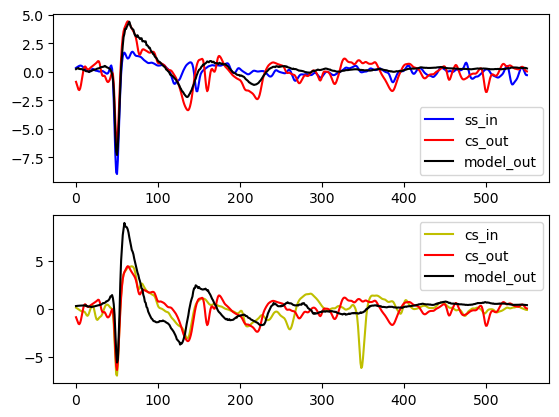

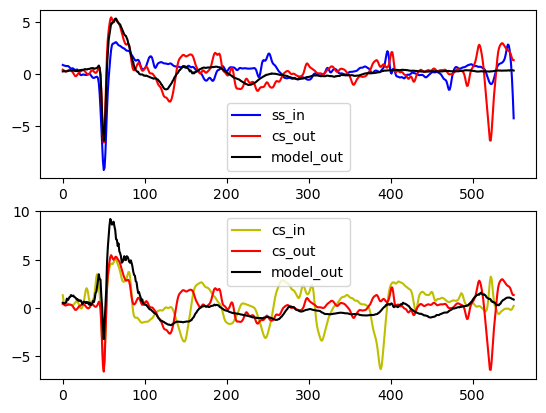

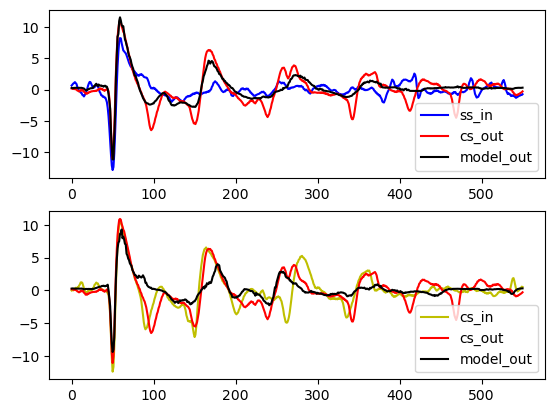

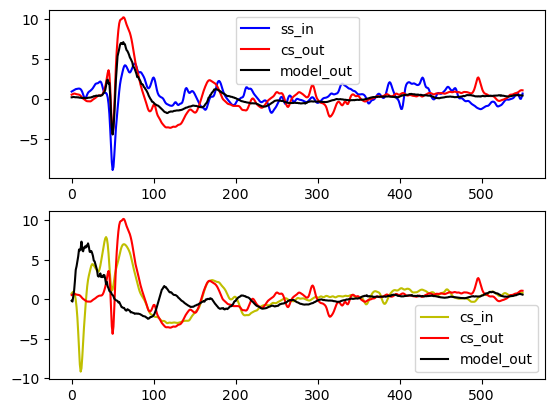

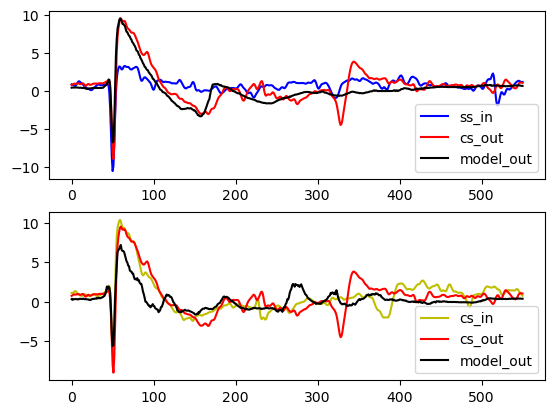

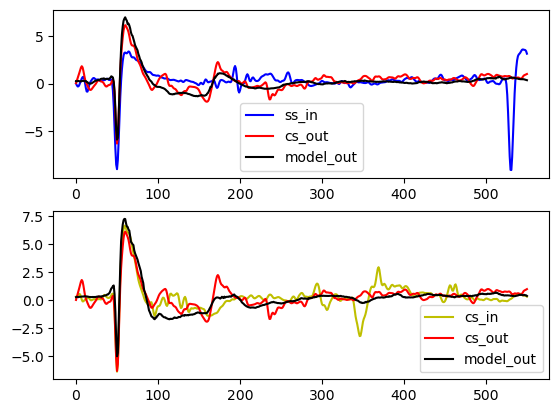

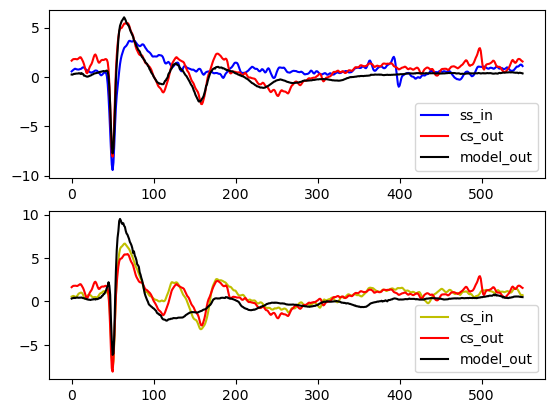

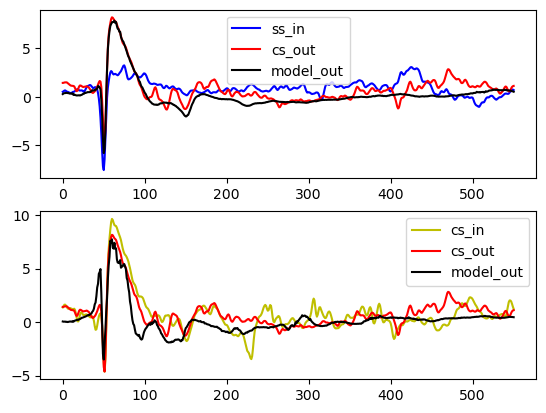

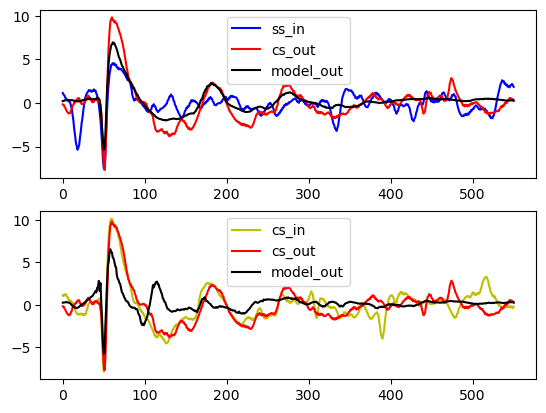

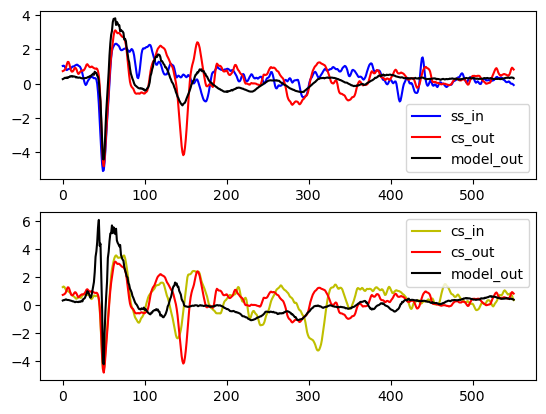

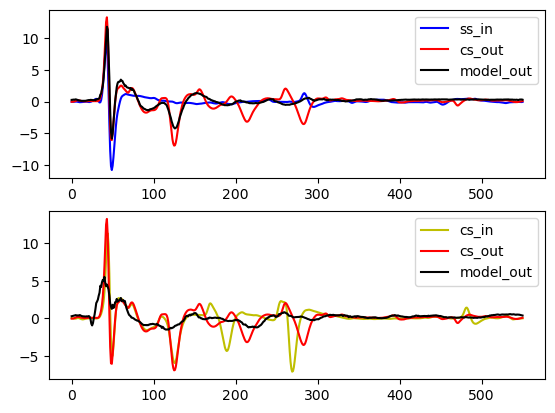

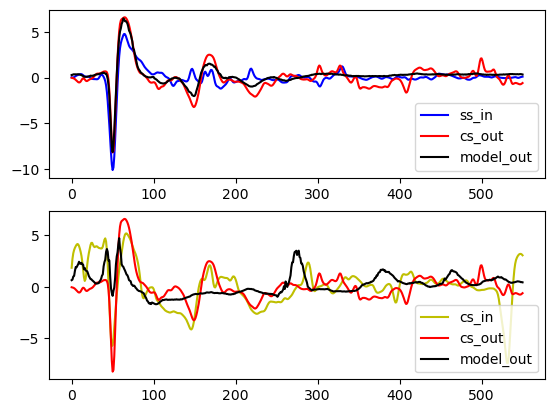

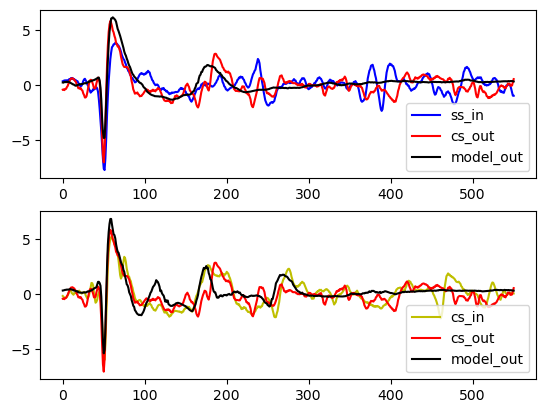

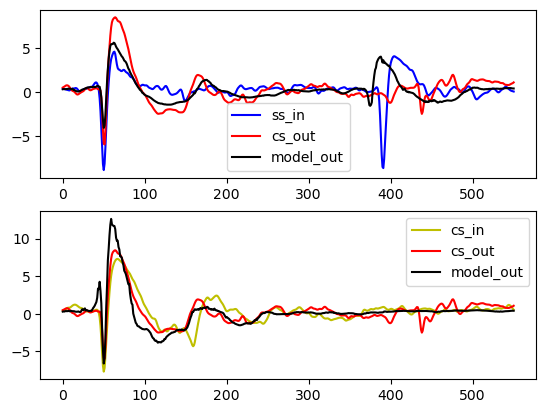

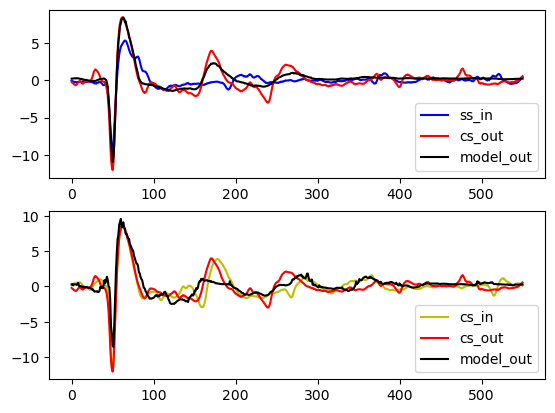

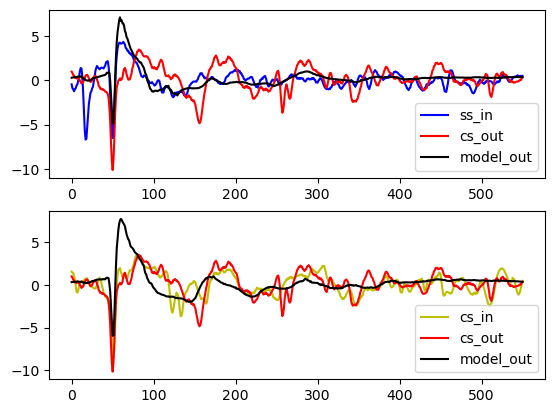

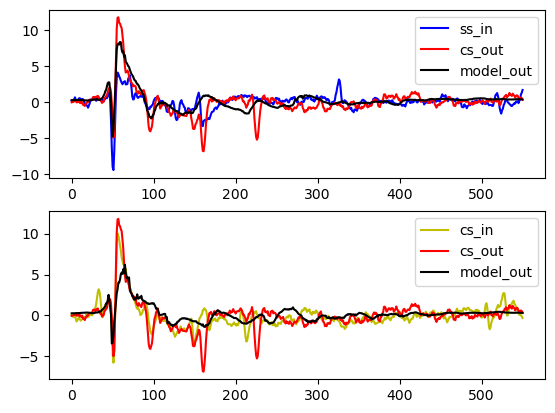

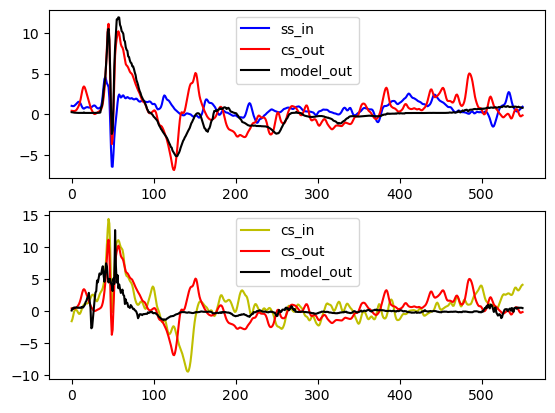

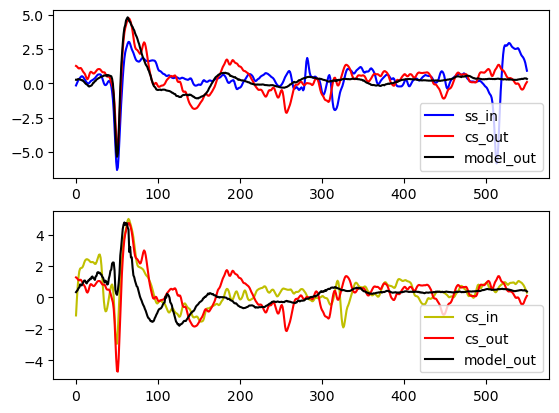

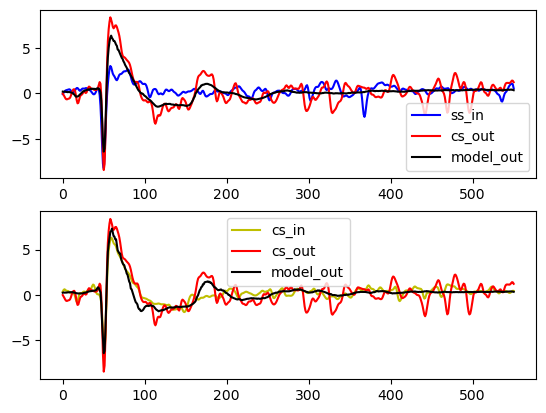

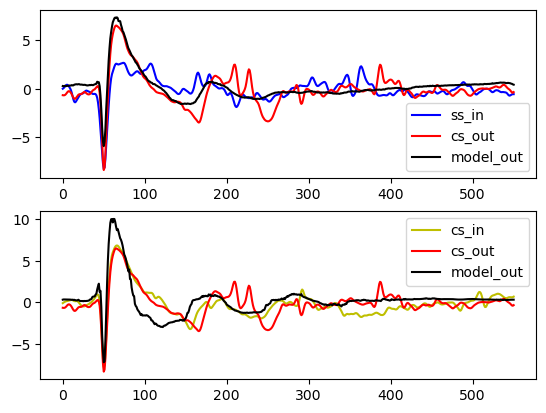

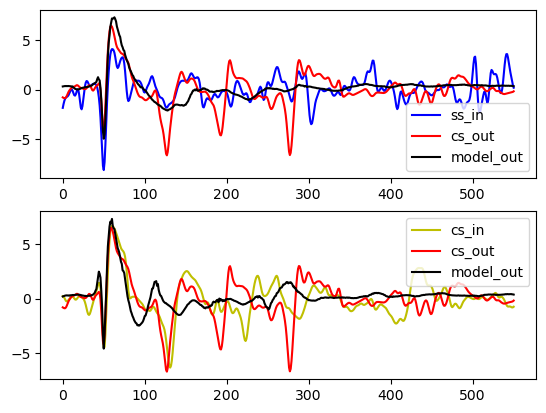

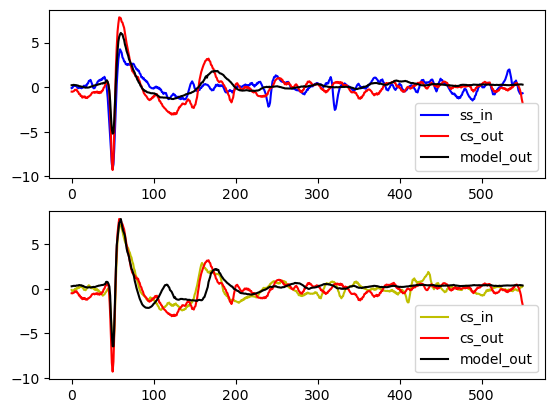

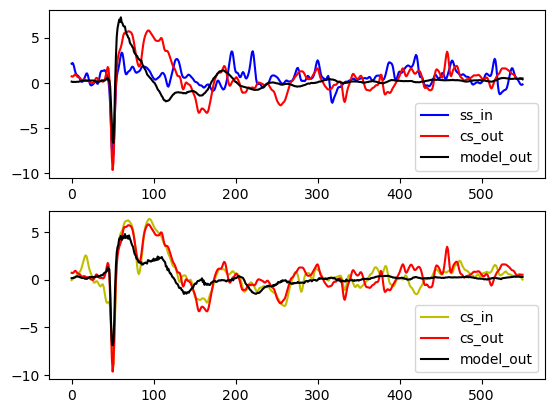

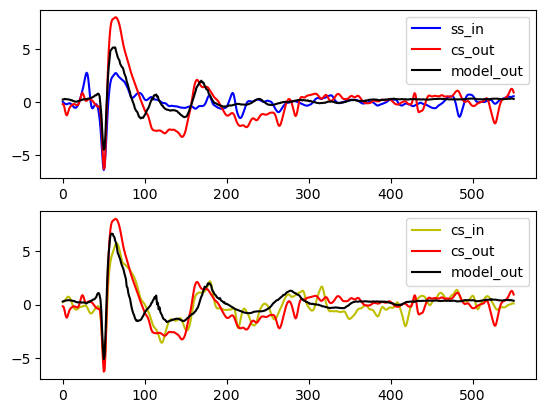

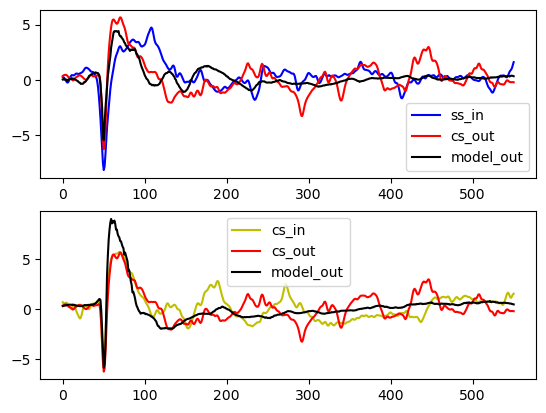

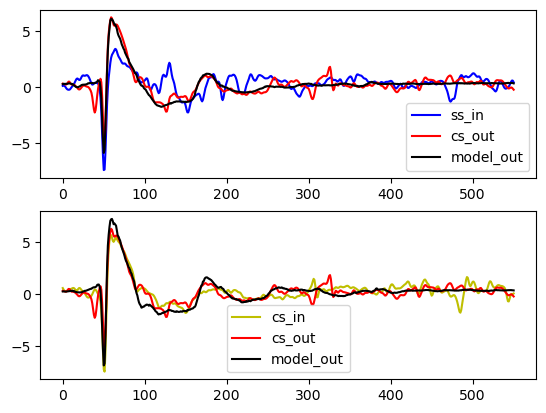

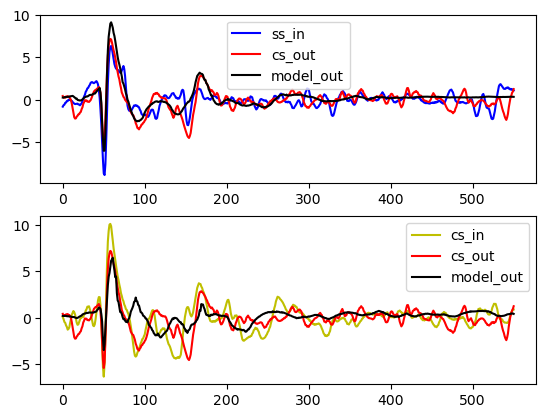

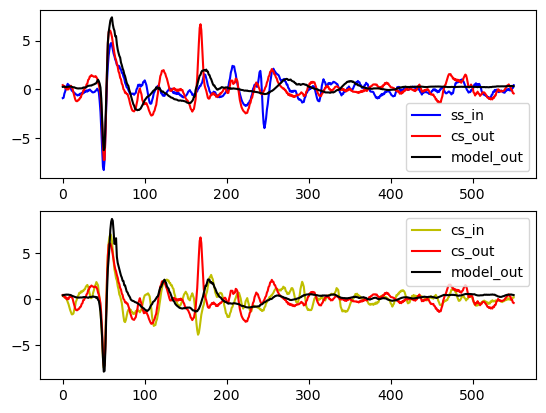

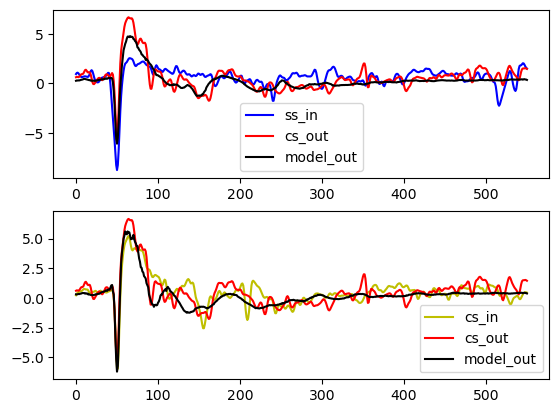

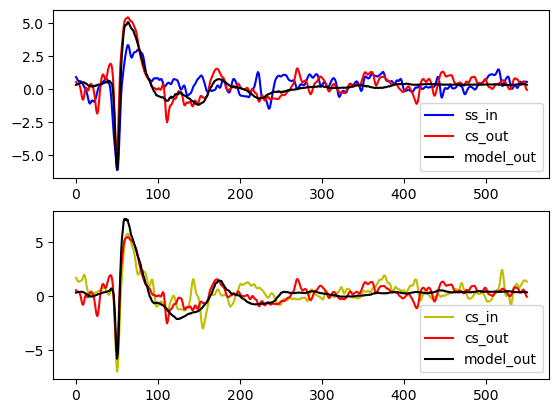

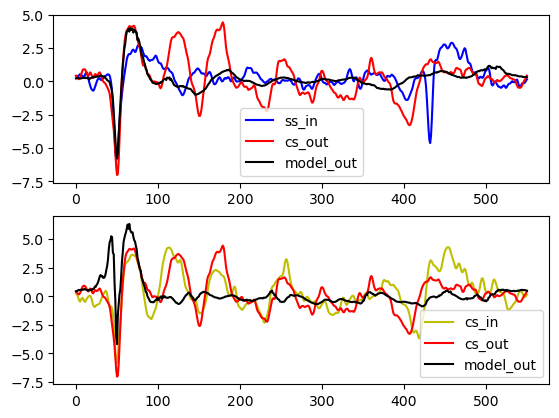

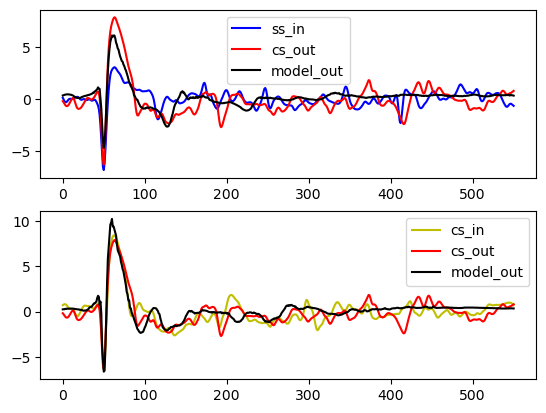

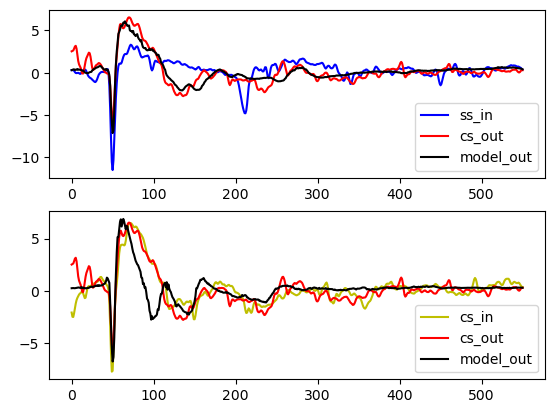

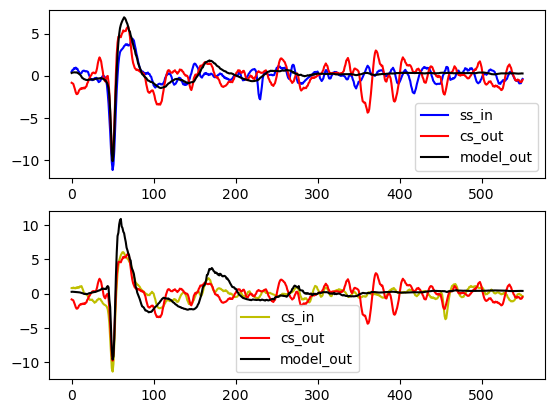

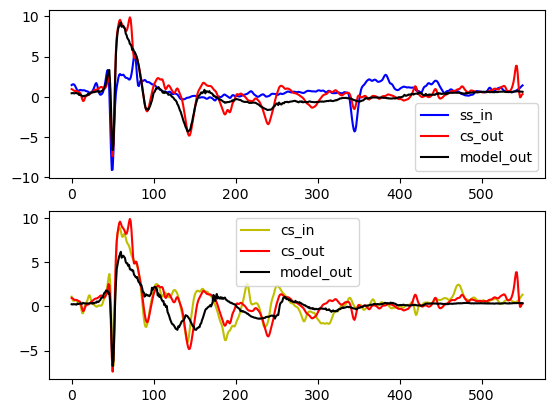

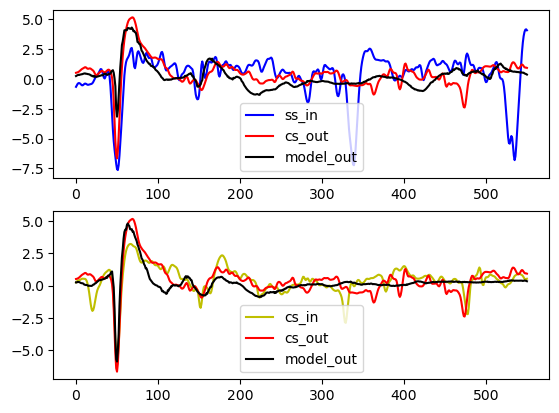

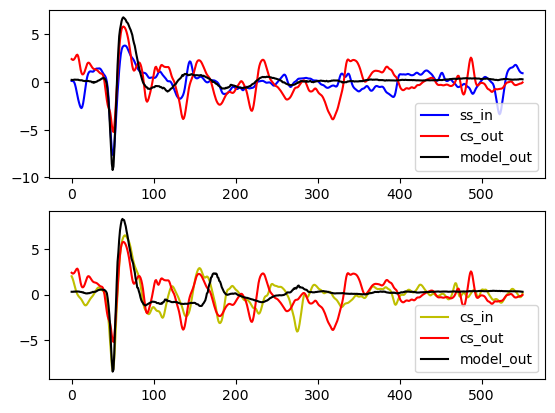

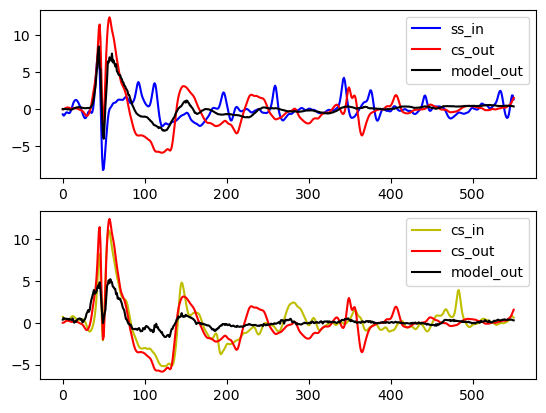

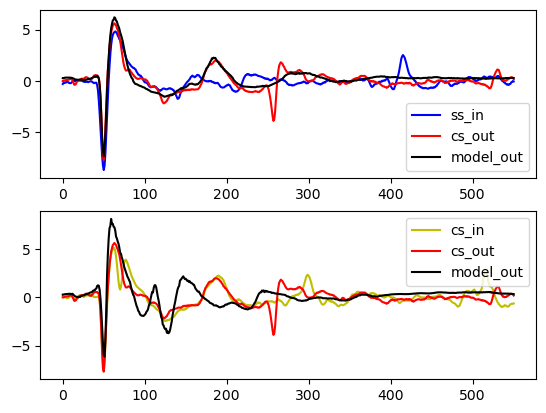

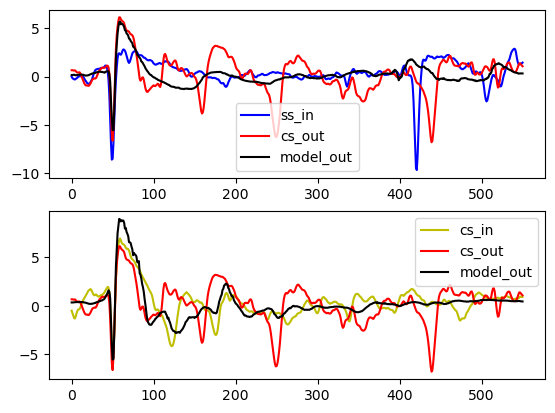

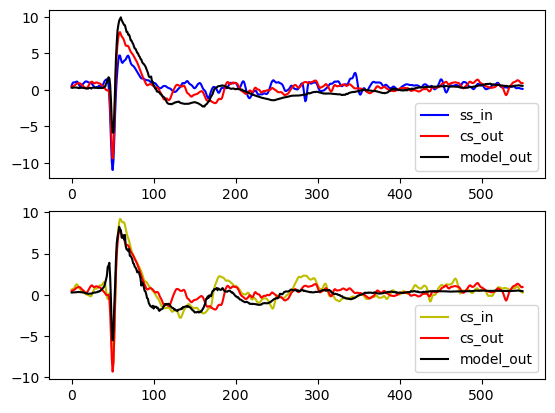

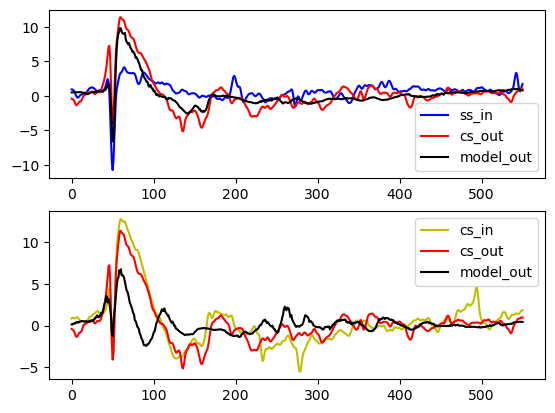

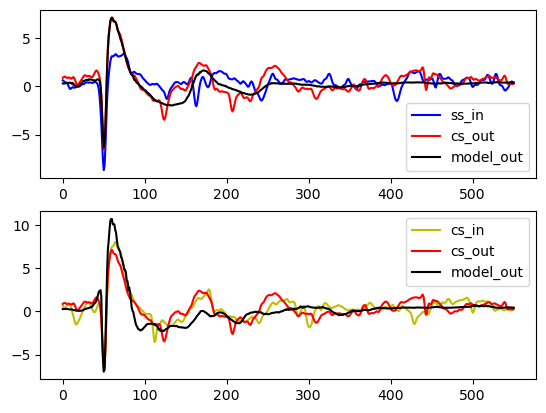

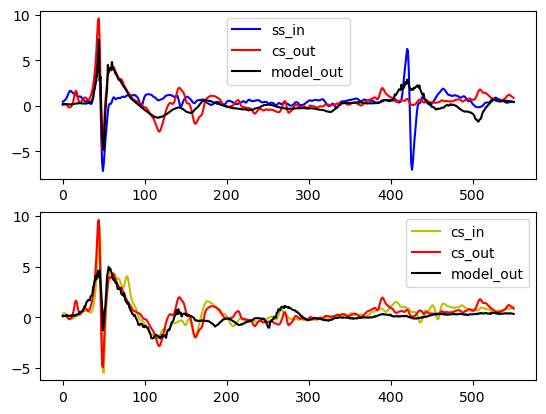

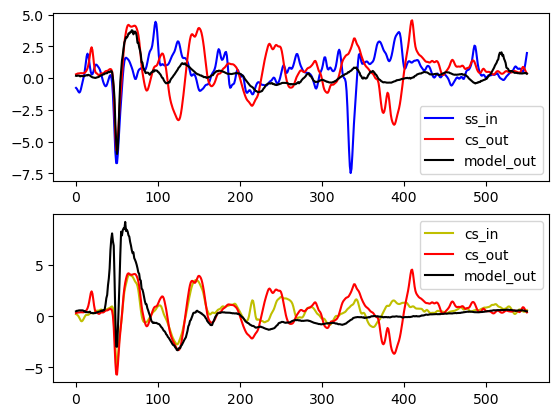

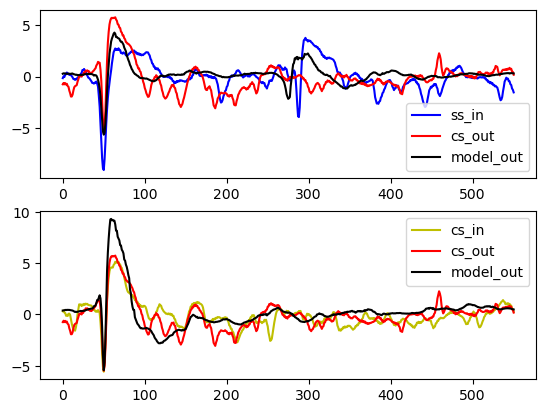

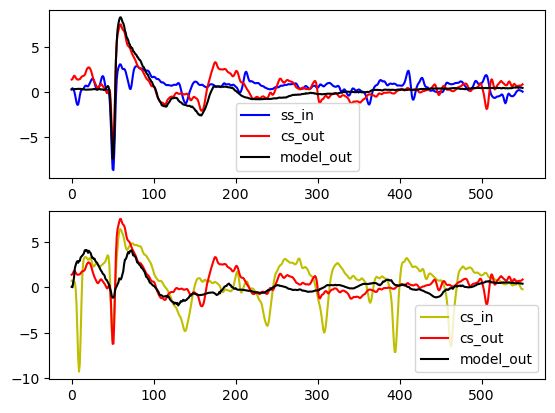

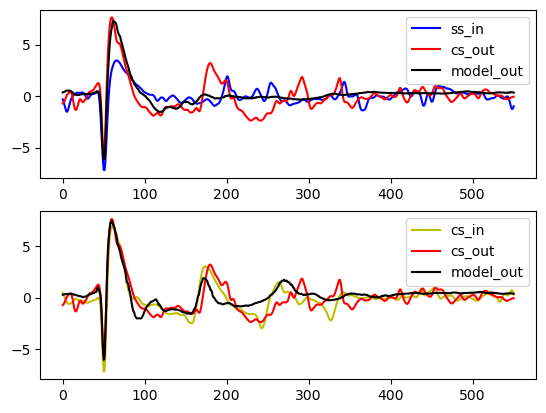

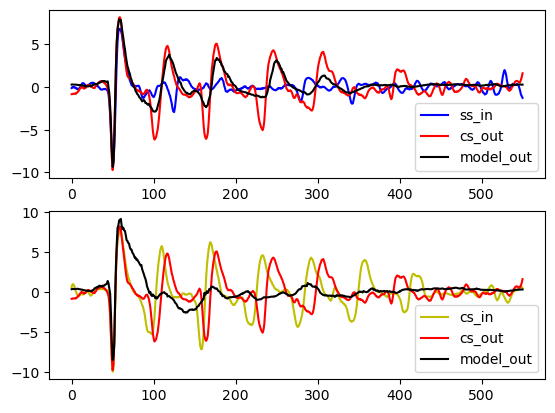

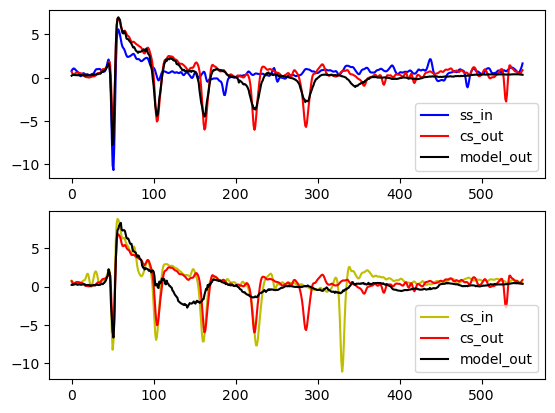

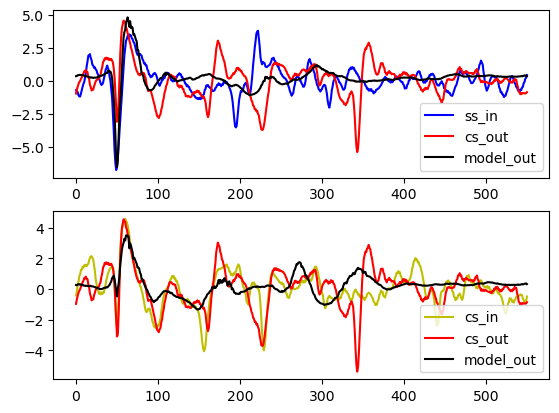

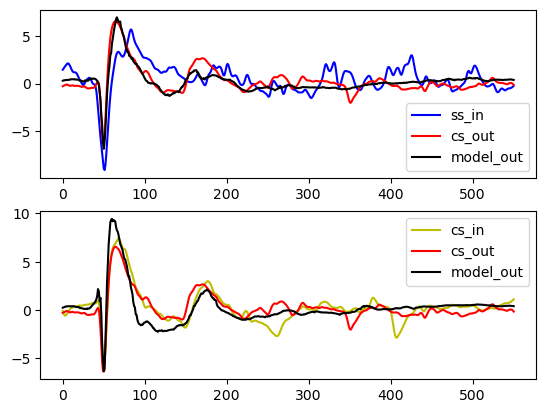

In [35]:
%matplotlib inline
# training set performance
model.eval()
device = torch.device("cpu")
model.to(device)
dataloader_train.dataset.minibatch = 1
for batch_idx,(cs_in,cs_out,ss_in,ss_out) in enumerate(dataloader_train):
    cs_in,cs_out,ss_in,ss_out = cs_in.to(device),cs_out.to(device),ss_in.to(device),ss_out.to(device)

    for i in range(53):
        model_out = model(ss_in)
        plt.figure()
        plt.subplot(211)
        plt.plot(ss_in[i,:],'b')
        plt.plot(cs_out[i,:],'r')
        plt.plot(model_out.detach().numpy()[i,:],'k')
        plt.legend(['ss_in','cs_out','model_out'])

        model_out = model(cs_in)
        plt.subplot(212)
        plt.plot(cs_in[i,:],'y')
        plt.plot(cs_out[i,:],'r')
        plt.plot(model_out.detach().numpy()[i,:],'k')
        plt.legend(['cs_in','cs_out','model_out'])
        plt.show()



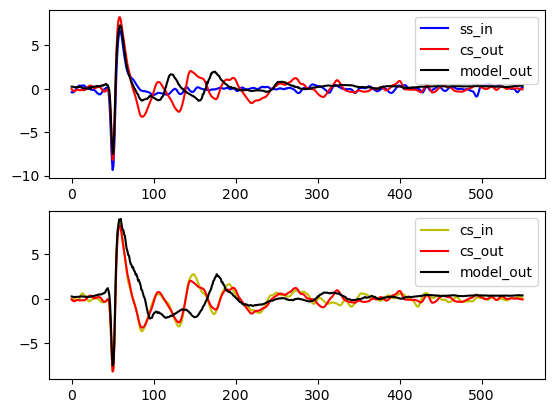

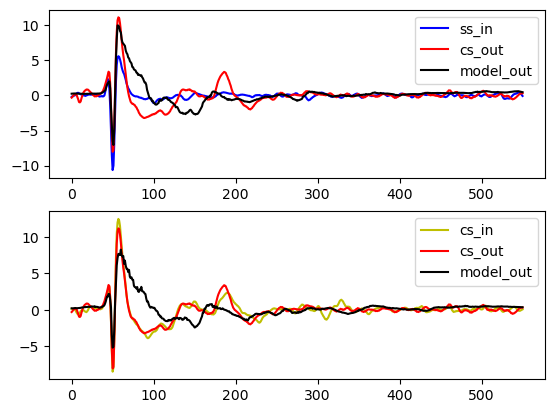

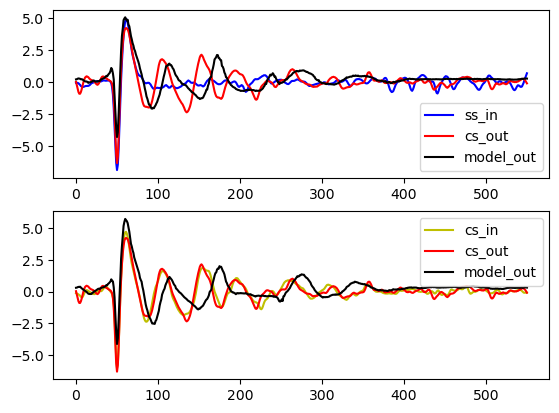

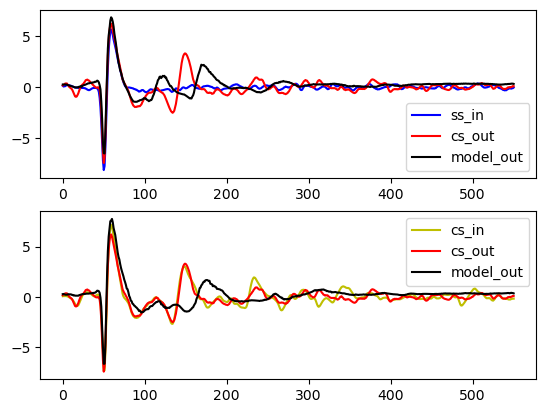

In [37]:
%matplotlib inline
# test set performance
model.eval()
device = torch.device("cpu")
model.to(device)
for batch_idx,(cs_in,cs_out,ss_in,ss_out) in enumerate(dataloader_test):
    cs_in,cs_out,ss_in,ss_out = cs_in.to(device),cs_out.to(device),ss_in.to(device),ss_out.to(device)

    for i in range(4):
        model_out = model(ss_in)
        plt.figure()
        plt.subplot(211)
        plt.plot(ss_in[i,:],'b')
        plt.plot(cs_out[i,:],'r')
        plt.plot(model_out.detach().numpy()[i,:],'k')
        plt.legend(['ss_in','cs_out','model_out'])

        model_out = model(cs_in)
        plt.subplot(212)
        plt.plot(cs_in[i,:],'y')
        plt.plot(cs_out[i,:],'r')
        plt.plot(model_out.detach().numpy()[i,:],'k')
        plt.legend(['cs_in','cs_out','model_out'])
        plt.show()

In [38]:
%matplotlib qt
data = loadmat('test_whole_data.mat')
data = data['test_whole_data']

# file 53
whole_trace = data[0][1]
whole_trace = torch.tensor(whole_trace).to(torch.float).T

whole_trace = whole_trace/std_data[54]*scale

model.eval()

plt.figure()
L_data_start = 500000
L_data = 10000
for tstart in range(L_data_start,L_data_start+L_data,500):
    temp = whole_trace[:,tstart+0:tstart+551]
    model_out = model(temp)
    plt.plot(range(tstart,tstart+551),temp[0,:],'b')
    plt.plot(range(tstart,tstart+551),model_out.detach().numpy()[0,:],'k')

# for tstart in range(L_data_start+L_data,L_data_start,-50):
#     temp = whole_trace[:,range(tstart+0,tstart-551,-1)]
#     model_out = model(temp)
#     plt.plot(range(tstart,tstart-551,-1),temp[0,:],'b')
#     plt.plot(range(tstart,tstart-551,-1),model_out.detach().numpy()[0,:]+1,'k')

plt.show()



In [27]:
%matplotlib qt
data = loadmat('NPXL_test_whole_data.mat')
data = data['NPXL_data']

whole_trace = data
whole_trace = torch.tensor(whole_trace).to(torch.float).T

whole_trace = whole_trace/torch.std(whole_trace)*scale

model.eval()

plt.figure()
L_data_start = 500000
L_data = 20000
for tstart in range(L_data_start,L_data_start+L_data,500):
    temp = whole_trace[:,tstart+0:tstart+551]
    model_out = model(temp)
    plt.plot(range(tstart,tstart+551),temp[0,:],'b')
    plt.plot(range(tstart,tstart+551),model_out.detach().numpy()[0,:],'k')

# for tstart in range(L_data_start+L_data,L_data_start,-50):
#     temp = whole_trace[:,range(tstart+0,tstart-551,-1)]
#     model_out = model(temp)
#     plt.plot(range(tstart,tstart-551,-1),temp[0,:],'b')
#     plt.plot(range(tstart,tstart-551,-1),model_out.detach().numpy()[0,:]+1,'k')

plt.show()

In [ ]:
print('debug')